### Initializing the API Handler

You should set the access parameters in the `local.py` of the project.

In [1]:
import twitter
from local import *
api = None
if CONSUMER_KEY:
    api = twitter.Api(
        consumer_key=CONSUMER_KEY,
        consumer_secret=CONSUMER_SECRET,
        access_token_key=ACCESS_TOKEN_KEY,
        access_token_secret=ACCESS_TOKEN_SECRET,
        sleep_on_rate_limit=True)

We have chosen 84 accounts to be analysed for this project.

In [2]:
from accounts import accounts
print("Number of accounts:", len(accounts))

Number of accounts: 84


### Fetching/Loading the Data

By default, this code loads previously fetched data from the data folder, unless it doesn't find the file related to an account. You can force to fetch even when the file exists by passing `from_internet_even_if_local_exists=True`.

By default, after fetching, this function stores the related data into a file for the account. You can disable this behavior by passing `save=False`.

In [3]:
import time

for account in accounts:
    try:
        f = account.fetch(api, from_internet_even_if_local_exists=False, save=True)
        if f:
            print("Fetched", account, " / followings:", len(account.followings), " / tweets:", len(account.tweets))
            time.sleep(10)
        else:
            print("Loaded", account, " / followings:", len(account.followings), " / tweets:", len(account.tweets))
    except:
        import sys
        print("Unexpected error for", account, ':', sys.exc_info()[0])

Loaded Ashraf Ghani 🇦🇫  / followings: 28  / tweets: 200
Loaded MFA Afghanistan 🇦🇫  / followings: 56  / tweets: 200
Loaded Mahmoud Saikal 🇦🇫  / followings: 454  / tweets: 200
Loaded Afghanistan Mission 🇦🇫  / followings: 295  / tweets: 200
Loaded Mauricio Macri 🇦🇷  / followings: 643  / tweets: 200
Loaded Jorge Faurie 🇦🇷  / followings: 200  / tweets: 200
Loaded Argentina at the United Nations 🇦🇷  / followings: 689  / tweets: 200
Loaded Scott Morrison 🇦🇺  / followings: 1753  / tweets: 200
Fetched Marise Payne 🇦🇺  / followings: 1720  / tweets: 200
Loaded Gillian Bird 🇦🇺  / followings: 678  / tweets: 200
Loaded Michel Temer 🇧🇷  / followings: 578  / tweets: 200
Loaded Aloysio Nunes 🇧🇷  / followings: 535  / tweets: 200
Loaded Itamaraty Brazil 🇧🇷  / followings: 841  / tweets: 200
Loaded Brazil Mission UN 🇧🇷  / followings: 614  / tweets: 199
Loaded Justin Trudeau 🇨🇦  / followings: 961  / tweets: 200
Loaded CanadianPM 🇨🇦  / followings: 1091  / tweets: 200
Fetched Chrystia Freeland 🇨🇦  / following

### Grouping the Accounts Based on the Country They Represent

In [4]:
countries = {}
for account in accounts:
    c = account.country_representing
    if account.country_representing:
        if c not in countries:
            countries[c] = [account]
        else:
            countries[c].append(account)

### Creating the Graph of the Countries Following Each Other

To create a graph aggregating how the grouped accounts are following each other, we set the weight of a connection from country `c1` to country `c2` equal to the percentage of the number of `c1` accounts being followed by a `c1` account, averaged for all the `c1` accounts.

In [5]:
c2c = {(c1, c2):0 for c1 in countries.keys() for c2 in countries.keys()}
for a1 in accounts:
    c1 = a1.country_representing
    if c1 not in countries:
        continue
    a1_screen_name = a1.twitter_handler.lower()
    for a2 in accounts:
        c2 = a2.country_representing
        if c2 not in countries:
            continue
        for f in a2.followings:
            if f.screen_name.lower() == a1_screen_name:
                c2c[(c2, c1)] += 1 / len(countries[c2]) / len(countries[c1])

To draw the graph, we use [networkx](https://networkx.github.io/) library.
Using the [`spring_layout`](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html),
we're creating a visualization where the proximity shows how members of the countries follow each other.

<IPython.core.display.Javascript object>


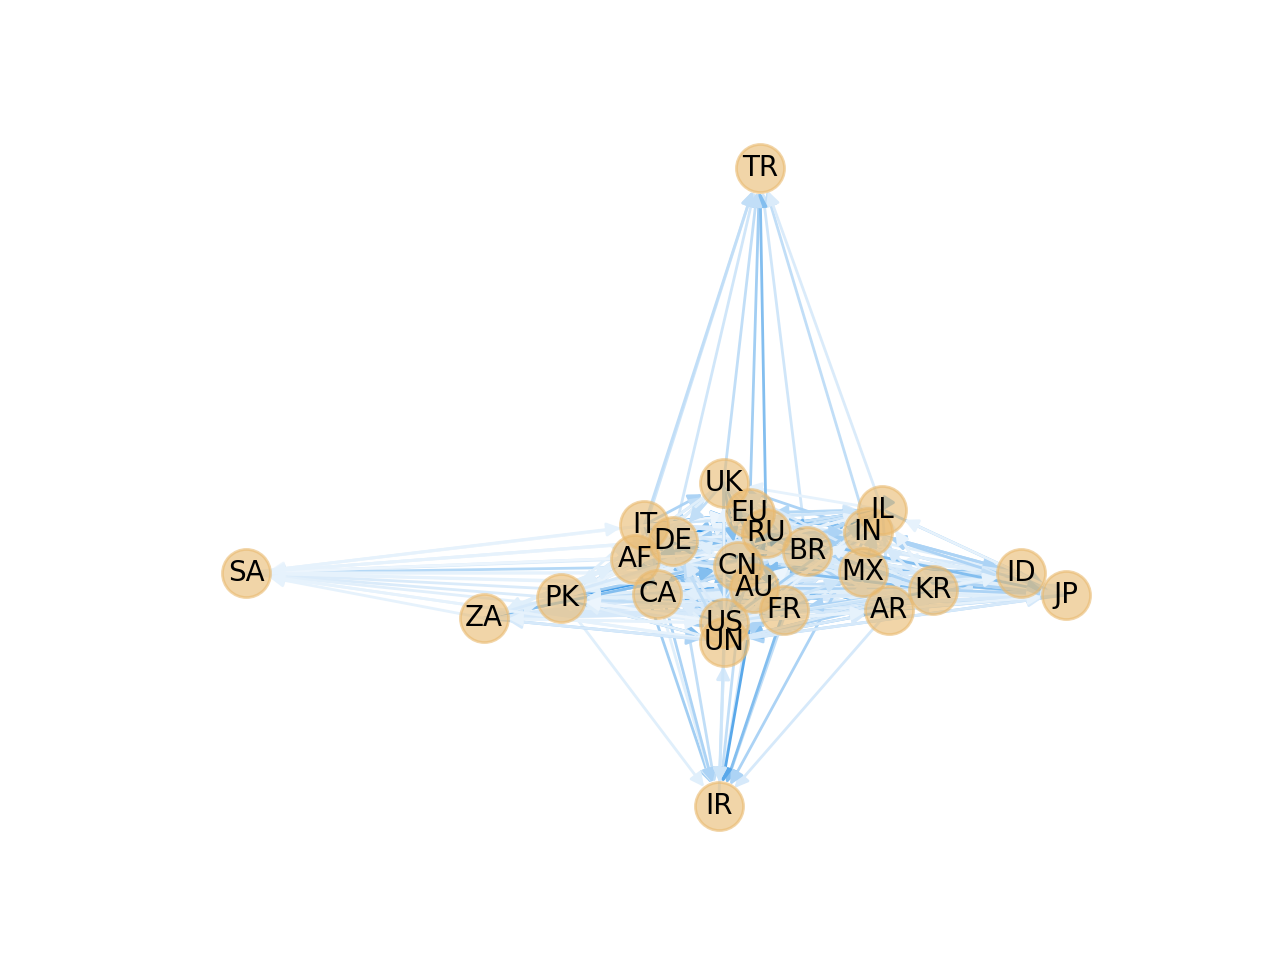

In [14]:
%matplotlib notebook
import networkx as nx
import matplotlib.pyplot as plt
from color_helper import shade_color

G = nx.DiGraph()
for c in countries:
    G.add_node(c)
for k, v in c2c.items():
    if v > 0.01:
        G.add_edge(k[0], k[1], weight=v)

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos,
                       node_color='#e9b96e', node_size=300, alpha=0.6)
for k, v in c2c.items():
    if v > 0.01:
        nx.draw_networkx_edges(G, pos,
                               edgelist=[(k[0], k[1])],
                               edge_color=[shade_color('#0a3050', v)])

nx.draw_networkx_labels(G,pos, font_size=10)

plt.axis('off')
plt.show()

### Creating the Graph of Countries Retweeting Each Other

To create a similar graph from retweets, we iterate through the tweets of each account (focused on only the last 120 days), and count the number of retweets of tweets by the other accounts. We normalize these values to defuse the impact of different frequencies of tweeting.

In [24]:
from datetime import datetime, timedelta


FOUR_MONTHS_AGO = datetime.strptime(accounts[-1].fetch_timestamp, '%Y-%m-%d %H:%M:%S.%f') - timedelta(days=120)

total_retweets = {a.twitter_handler.lower(): 0 for a in accounts}
country_retweets = {(a.twitter_handler.lower(), c): 0 for a in accounts for c in countries.keys()}
account_handlers = {a.twitter_handler.lower(): a for a in accounts}
for a1 in accounts:
    c1 = a1.country_representing
    if c1 not in countries:
        continue
    for t in a1.tweets:
        if datetime.strptime(t.created_at, '%a %b %d %H:%M:%S +0000 %Y') < FOUR_MONTHS_AGO:
            break
        if hasattr(t, 'retweeted_status') and t.retweeted_status:
            total_retweets[a1.twitter_handler.lower()] += 1
            a2_handler = t.retweeted_status.user.screen_name
            if a2_handler in account_handlers:
                c2 = account_handlers[a2_handler].country_representing
                if c2 in countries:
                    country_retweets[(a1.twitter_handler.lower(), c2)] += 1
                    
c2c_retweets = {}
for c1 in countries.keys():
    for c2 in countries.keys():
        c2c_retweets[(c1, c2)] = 0
        for a in countries[c1]:
            if total_retweets[a.twitter_handler.lower()] > 0:
                c2c_retweets[(c1, c2)] += country_retweets[(a.twitter_handler.lower(), c2)] / total_retweets[a.twitter_handler.lower()] / len(countries[c1])


<IPython.core.display.Javascript object>


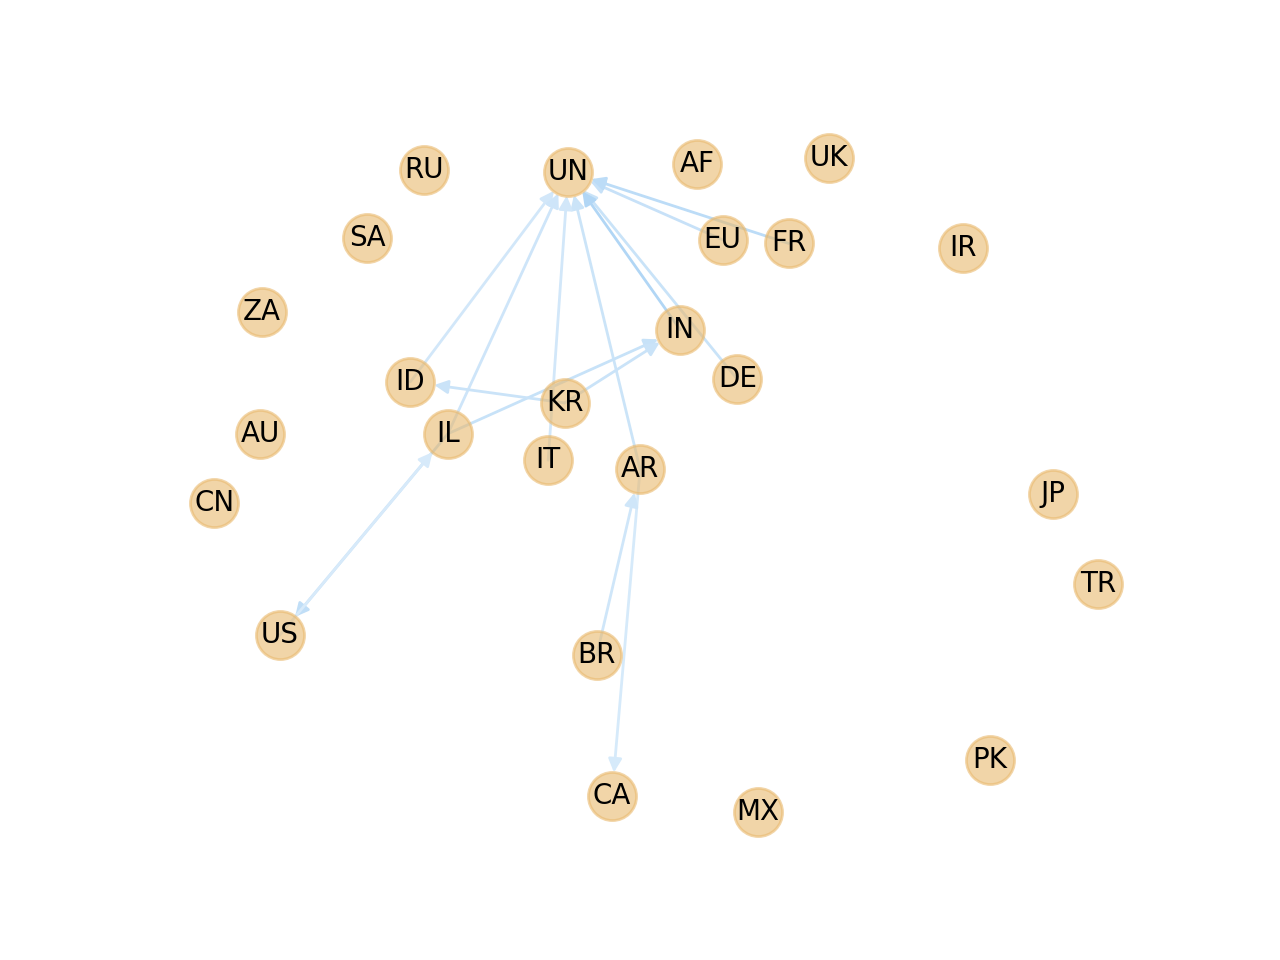

In [6]:
%matplotlib notebook
import math
import networkx as nx
import matplotlib.pyplot as plt
from color_helper import shade_color

G = nx.DiGraph()
for c in countries:
    G.add_node(c)
for k, v in c2c_retweets.items():
    if v > 0.01:
        G.add_edge(k[0], k[1], weight=v)

pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx_nodes(G, pos,
                       node_color='#e9b96e', node_size=300, alpha=0.6)
for k, v in c2c_retweets.items():
    if v > 0.01:
        nx.draw_networkx_edges(G, pos,
                               edgelist=[(k[0], k[1])],
                               edge_color=[shade_color('#0a3050', math.sqrt(v))])

nx.draw_networkx_labels(G,pos, font_size=10)

plt.axis('off')
plt.show()

### A Word Cloud of All the Recent Tweets by the Chosen Acccounts

In [7]:
import re

FOUR_MONTHS_AGO = datetime.strptime(accounts[-1].fetch_timestamp, '%Y-%m-%d %H:%M:%S.%f') - timedelta(days=120)

text = ""
url_remover = re.compile(r'http\S+')
for a1 in accounts:
    for t in a1.tweets:
        if datetime.strptime(t.created_at, '%a %b %d %H:%M:%S +0000 %Y') < FOUR_MONTHS_AGO:
            break
        s = t.text
        if s.startswith("RT "):
            s = s[3:]
        s = url_remover.sub('', s)
        if 'http' in s:
            print(s)
        text += " " + s


<IPython.core.display.Javascript object>


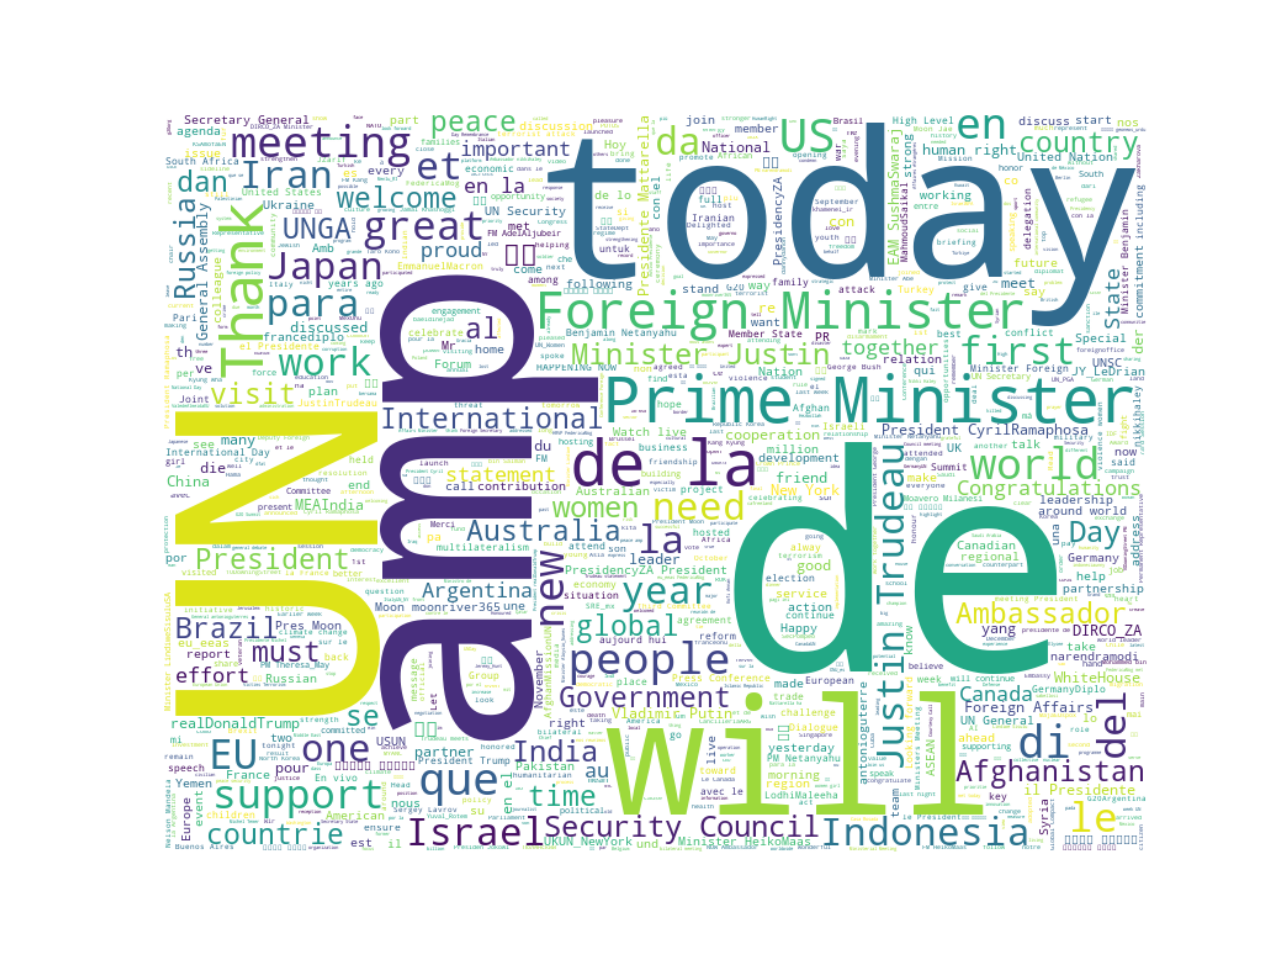

In [8]:
%matplotlib notebook
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color="white", max_words=1000, width=800, height=600).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### A Word Cloud of All the Hashtags

<IPython.core.display.Javascript object>


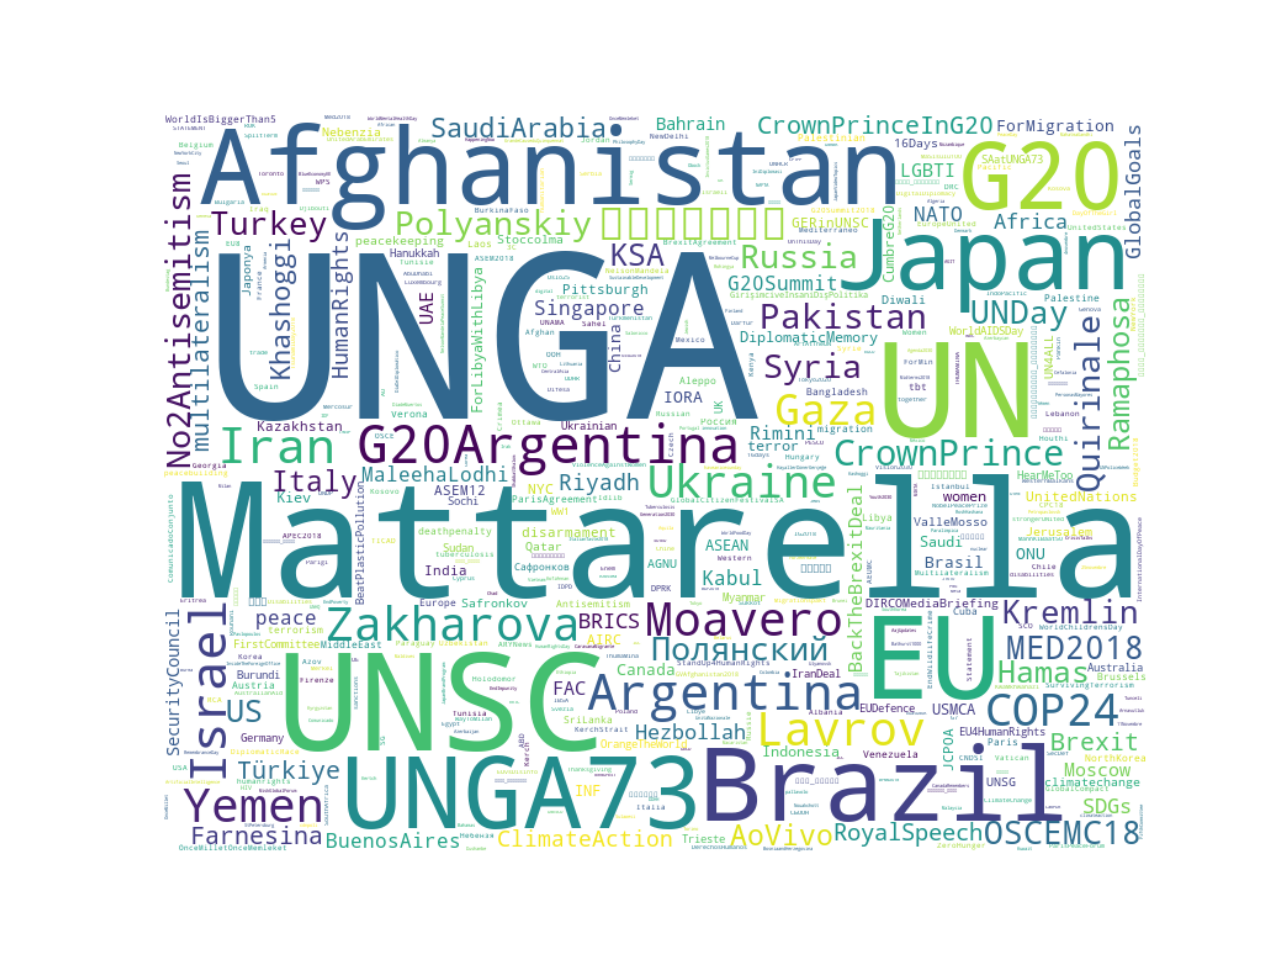

In [23]:
import re

FOUR_MONTHS_AGO = datetime.strptime(accounts[-1].fetch_timestamp, '%Y-%m-%d %H:%M:%S.%f') - timedelta(days=120)

words = {}
max_freq = 0
for a1 in accounts:
    for t in a1.tweets:
        if datetime.strptime(t.created_at, '%a %b %d %H:%M:%S +0000 %Y') < FOUR_MONTHS_AGO:
            break
        if t.hashtags:
            for h in t.hashtags:
                words[h.text] = words.get(h.text, 0) + 1
                if words[h.text] > max_freq:
                    max_freq = words[h.text]

words = {h: freq / max_freq for h, freq in words.items()}

%matplotlib notebook
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color="white", max_words=1000, width=800, height=600)
wordcloud = wordcloud.generate_from_frequencies(words)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### A Timeline of All the Tweets by the Chosen Acccounts Mentioning "khashoggi"

In [17]:
from datetime import datetime, date, timedelta
import re

START = datetime(2018, 9, 20)
KEYWORDS = ("khashoggi", "خاشقجي", "خاشقجی")

text = ""
url_remover = re.compile(r'http\S+')
timeline = {
    datetime(2018, 10, 2, 13, 14): "[Mr. Khashoggi entered the consulate]",
}
tweets = 0
for a1 in accounts:
    c1 = a1.country_representing
    if c1 not in countries:
        continue
    for t in a1.tweets:
        d = datetime.strptime(t.created_at, '%a %b %d %H:%M:%S +0000 %Y')
        if d < START:
            break
        tweets += 1
        related = False
        for k in KEYWORDS:
            if k in t.text.lower():
                related = True
                continue
        if not related:
            continue
        timeline[d] = a1.country_representing
        s = t.text
        if s.startswith("RT "):
            s = s[3:]
        s = url_remover.sub('', s)
        text += " " + s

dates = sorted(list(timeline.keys()))

<IPython.core.display.Javascript object>


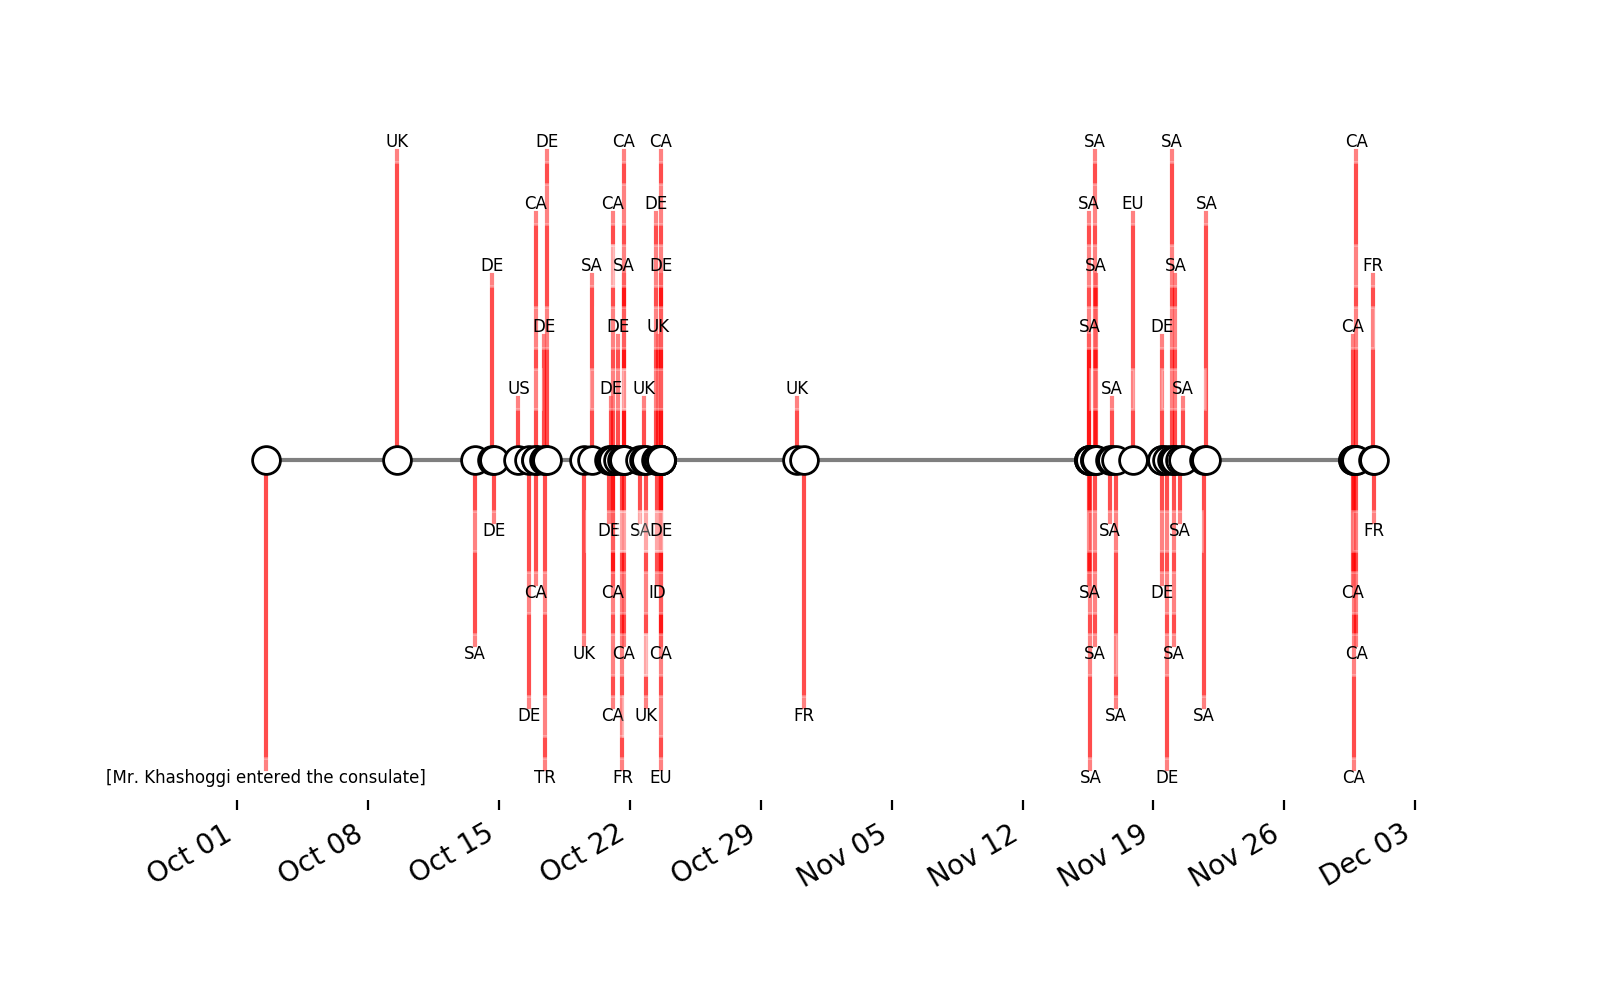

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

levels = np.array([-5, 5, -3, 3, -1, 1, -4, 4, -2, 2])
fig, ax = plt.subplots(figsize=(8, 5))

# Create the base line
start = min(dates)
stop = max(dates)
ax.plot((start, stop), (0, 0), 'k', alpha=.5)

for ii, idate in enumerate(dates):
    iname = timeline[idate]
    level = levels[ii % len(levels)]
    vert = 'top' if level < 0 else 'bottom'

    ax.scatter(idate, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)
    ax.plot((idate, idate), (0, level), c='r', alpha=.7)
    ax.text(idate, level, iname,
            horizontalalignment='center', verticalalignment=vert, fontsize=6,
            backgroundcolor=(1., 1., 1., .3))
ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=7))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate()

plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
          list(ax.spines.values())), visible=False)
plt.show()

<IPython.core.display.Javascript object>


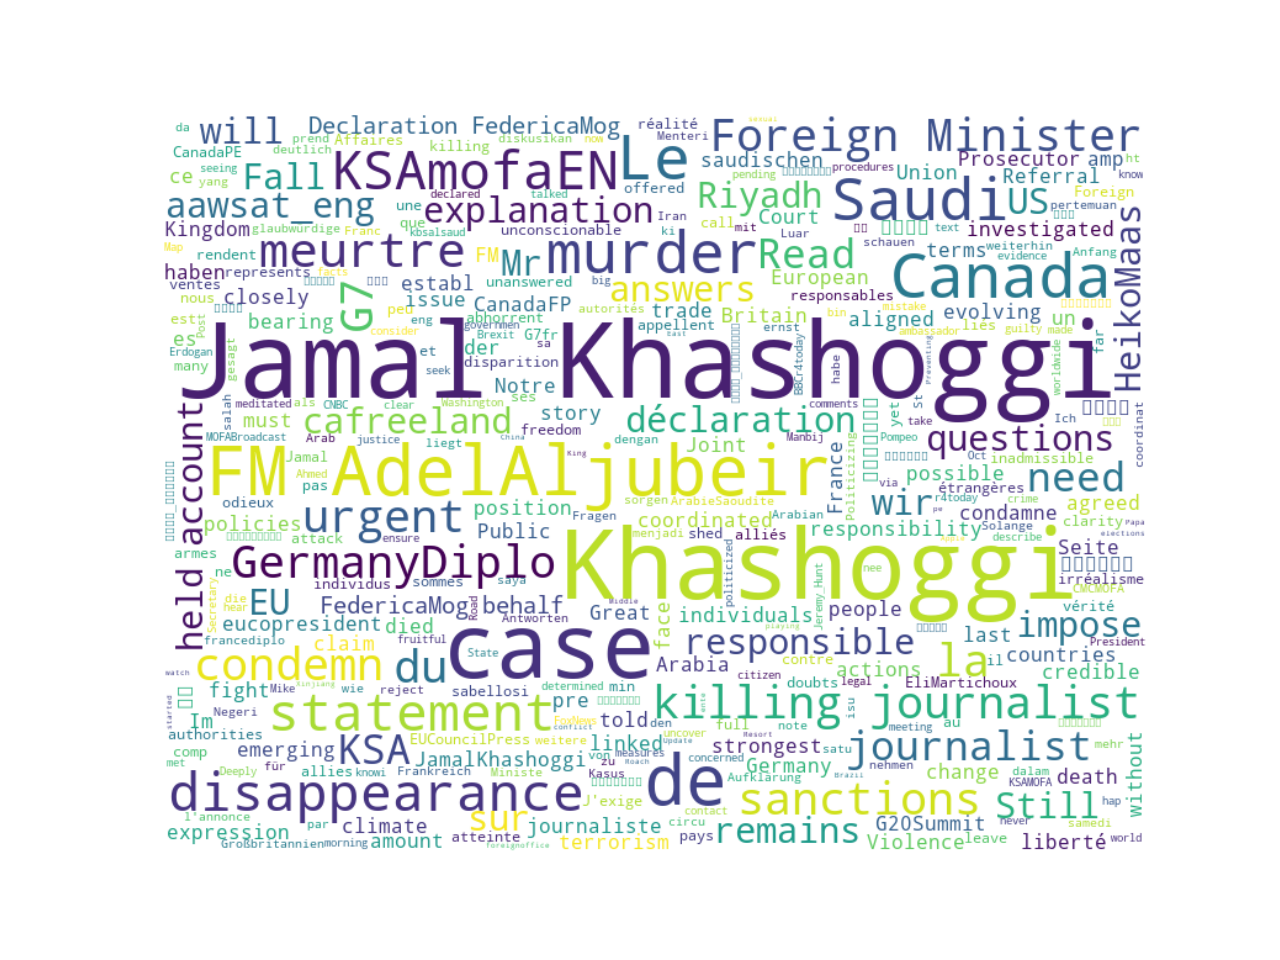

In [19]:
%matplotlib notebook
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color="white", max_words=1000, width=800, height=600).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
